# Курсовая работа  
## Классификация постов сообществ ВКонтакте по тематике железнодорожного и водного транспорта

В этом ноутбуке реализован полный код курсовой работы: от сбора постов из двух сообществ «ВКонтакте» до обучения модели, которая по тексту поста определяет, относится ли он к теме железнодорожного или водного транспорта.

## 1. Импорт библиотек и настройка окружения

На этом шаге подключаем все необходимые библиотеки:  
- для работы с данными (`pandas`, `numpy`);  
- для визуализации (`matplotlib`, `seaborn`);  
- для предобработки текста (`nltk`, `razdel`, `pymorphy2`, `emoji`);  
- для работы с VK API (`requests`, `vk_api`);  
- для обучения и оценки моделей (`scikit-learn`).

In [ ]:
import os
import re
from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import vk_api 

import nltk
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2
import emoji

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

### 1.1. Загрузка стоп-слов и инициализация морфологического анализатора

In [ ]:
nltk.download("stopwords")

russian_stopwords = set(stopwords.words("russian"))

morph = pymorphy2.MorphAnalyzer()

plt.rcParams["figure.figsize"] = (10, 5)
sns.set(style="whitegrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vohmin.ae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2. Пример лемматизации

In [38]:
test_text = "Поезд прибыл на станцию вовремя 🚂"
print("Оригинальный текст:", test_text)

tokens = [t.text for t in tokenize(test_text.lower())]
print("Токены:", tokens)

for token in tokens:
    if token.isalpha():
        lemma = morph.parse(token)[0].normal_form
        print(f"Слово: {token} -> лемма: {lemma}")
        break

Оригинальный текст: Поезд прибыл на станцию вовремя 🚂
Токены: ['поезд', 'прибыл', 'на', 'станцию', 'вовремя', '🚂']
Слово: поезд -> лемма: поезд


## 2. Сбор данных из ВКонтакте

### 2.1. Загрузка токена и настройка параметров VK API

In [13]:
# Вставьте сюда свой access_token, полученный из адресной строки!
token='vk1.a.eqMpad3jMAXIiLU1TbqjYV0h7iMDgQlDBsqx_WeptatWrjI3tLKy9GCUR5a9Z0fcoBeeoI-sa44p5LUuLfGlj54CHBwrgkxrIZYrI5RNd_9DIIcyMOu3ov8zGG7Qt_FKEfrcRDy9la24c8QVMqfXhhJfmZs8r7GoIQT51te-aaQsxkG7R7v0IjqhybSf4q0tn3BL1BKD-F3TCFLvdJ7z3Q'

In [ ]:
VK_API_VERSION = "5.199"

GROUP_ID_RAIL = 'rzd_official'     
GROUP_ID_WATER = 'fleet_history'  


### 2.2. Функция для выгрузки постов методом `wall.get`

In [ ]:
VK_API_URL = "https://api.vk.com/method/wall.get"


def get_wall_posts(
    owner_id: int,
    token: str,
    max_posts: int = 10000,
    chunk_size: int = 100,
):
    """
    Скачивает посты со стены сообщества VK и возвращает DataFrame.

    owner_id: отрицательный ID сообщества (например, -38981315)
    token: access_token VK
    max_posts: максимальное количество постов, которые хотим получить
    chunk_size: сколько постов запрашиваем за один запрос (максимум 100)
    """
    all_posts = []
    offset = 0

    while offset < max_posts:
        params = {
            "access_token": token,
            "owner_id": owner_id,
            "count": chunk_size,
            "offset": offset,
            "v": VK_API_VERSION,
            "filter": "owner", 
        }

        response = requests.get(VK_API_URL, params=params)
        data = response.json()

        if "error" in data:
            print("VK API error:", data["error"])
            break

        items = data["response"]["items"]
        if not items:
            break

        for item in items:
            text = item.get("text", "")
            if not text.strip():
                continue

            post_info = {
                "post_id": item.get("id"),
                "date": pd.to_datetime(item.get("date"), unit="s"),
                "owner_id": item.get("owner_id"),
                "text": text,
                "likes": item.get("likes", {}).get("count", 0),
                "reposts": item.get("reposts", {}).get("count", 0),
                "comments": item.get("comments", {}).get("count", 0),
                "views": item.get("views", {}).get("count", 0),
            }
            all_posts.append(post_info)

        offset += chunk_size

        if len(all_posts) >= max_posts:
            break

    df_posts = pd.DataFrame(all_posts)
    return df_posts

### 2.3. Выгрузка постов из двух сообществ

In [16]:
df_rail_raw = get_wall_posts(GROUP_ID_RAIL, token, max_posts=3000)
df_water_raw = get_wall_posts(GROUP_ID_WATER, token, max_posts=3000 )

print("Ж/д группа — постов:", len(df_rail_raw))
print("Водный транспорт — постов:", len(df_water_raw))

df_rail_raw.head()

Ж/д группа — постов: 2383
Водный транспорт — постов: 2661


,post_id,date,owner_id,text,likes,reposts,comments,views
0,391476,2025-12-10 09:30:00,-38981315,С 1 декабря у всех наших пассажиров появился н...,118,18,26,17340
1,391402,2025-12-09 09:30:42,-38981315,Уже почти год между Москвой и Санкт-Петербурго...,399,36,60,55617
2,391316,2025-12-08 09:30:22,-38981315,"В Амурской области есть станция, которую уважи...",90,7,13,8069
3,391008,2025-12-05 09:30:53,-38981315,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",190,100,138,20617
4,390810,2025-12-04 09:30:03,-38981315,В тепло через снега: двухэтажный поезд Москва ...,780,60,100,33983


In [17]:
df_water_raw.head()

,post_id,date,owner_id,text,likes,reposts,comments,views
0,36627,2015-06-20 17:30:00,-2169946,"Работы художника Atsushi Yamashita на тему ""Ру...",3516,636,326,0
1,348777,2025-12-10 16:00:00,-2169946,"Тяжёлый крейсер Дюкен на Хэмптон-Роудс, 15 окт...",29,3,2,952
2,348773,2025-12-10 15:00:01,-2169946,Бронепалубный крейсер Лигурия на стапеле верфи...,19,0,0,515
3,348771,2025-12-10 14:30:00,-2169946,"Линкор Дюнкерк, монументален. \n1940г\n#Линкор...",47,3,0,794
4,348762,2025-12-10 13:00:00,-2169946,Спуск лёгкого крейсера Орион на казённой верфи...,22,0,0,689


## 3. Формирование корпуса и первичная фильтрация

На этом шаге формируется единый датасет:

- добавляю метки классов (`group` и `target`) для каждого сообщества;
- объединяю посты в общий `DataFrame`;
- удаляю пустые тексты и слишком короткие сообщения;
- убираю дубликаты.

В результате получаю корпус из уникальных постов двух тематик.

In [ ]:
df_rail = df_rail_raw.copy()
df_water = df_water_raw.copy()

df_rail["group"] = "rail"     
df_water["group"] = "water"    

label_mapping = {"rail": 0, "water": 1}
df_rail["target"] = df_rail["group"].map(label_mapping)
df_water["target"] = df_water["group"].map(label_mapping)

cols_to_keep = ["post_id", "date", "text", "likes", "reposts", "comments", "views", "group", "target"]
df_rail = df_rail[cols_to_keep]
df_water = df_water[cols_to_keep]

df = pd.concat([df_rail, df_water], ignore_index=True)

print("Общий датасет:", df.shape)
print(df["group"].value_counts())
df.head()

Общий датасет: (5044, 9)
group
water    2661
rail     2383
Name: count, dtype: int64


,post_id,date,text,likes,reposts,comments,views,group,target
0,391476,2025-12-10 09:30:00,С 1 декабря у всех наших пассажиров появился н...,118,18,26,17340,rail,0
1,391402,2025-12-09 09:30:42,Уже почти год между Москвой и Санкт-Петербурго...,399,36,60,55617,rail,0
2,391316,2025-12-08 09:30:22,"В Амурской области есть станция, которую уважи...",90,7,13,8069,rail,0
3,391008,2025-12-05 09:30:53,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",190,100,138,20617,rail,0
4,390810,2025-12-04 09:30:03,В тепло через снега: двухэтажный поезд Москва ...,780,60,100,33983,rail,0


In [ ]:
df["text"] = df["text"].astype(str)

df["text_stripped"] = df["text"].str.strip()
df = df[df["text_stripped"] != ""].copy()

df["text_len"] = df["text_stripped"].str.len()

min_len = 20
df = df[df["text_len"] >= min_len].copy()

df = df.drop_duplicates(subset="text_stripped").reset_index(drop=True)

print("После фильтрации:", df.shape)
print(df["group"].value_counts())
df.head()

После фильтрации: (4942, 11)
group
water    2570
rail     2372
Name: count, dtype: int64


,post_id,date,text,likes,reposts,comments,views,group,target,text_stripped,text_len
0,391476,2025-12-10 09:30:00,С 1 декабря у всех наших пассажиров появился н...,118,18,26,17340,rail,0,С 1 декабря у всех наших пассажиров появился н...,1124
1,391402,2025-12-09 09:30:42,Уже почти год между Москвой и Санкт-Петербурго...,399,36,60,55617,rail,0,Уже почти год между Москвой и Санкт-Петербурго...,706
2,391316,2025-12-08 09:30:22,"В Амурской области есть станция, которую уважи...",90,7,13,8069,rail,0,"В Амурской области есть станция, которую уважи...",79
3,391008,2025-12-05 09:30:53,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",190,100,138,20617,rail,0,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",723
4,390810,2025-12-04 09:30:03,В тепло через снега: двухэтажный поезд Москва ...,780,60,100,33983,rail,0,В тепло через снега: двухэтажный поезд Москва ...,98


## 4. Предобработка текстов

### 4.1. Базовая очистка (`clean_text`)

Очищаем тексты от технического шума:

- приводим к нижнему регистру;
- удаляем ссылки и упоминания;
- убираем HTML-сущности;
- переводим эмодзи в текст и вычищаем лишние символы;
- сжимаем повторяющиеся пробелы.

Результат сохраняем в колонку `text_clean`.

In [ ]:
url_pattern = re.compile(r"https?://\S+|www\.\S+")
mention_pattern = re.compile(r"\[club\d+\|.*?]")  
html_pattern = re.compile(r"&[a-zA-Z]+;")       


def clean_text(text: str) -> str:
    """
    Базовая очистка текста:
    - приведение к нижнему регистру
    - удаление ссылок, html-сущностей, упоминаний
    - замена эмодзи на текстовое описание
    - удаление лишних символов и пробелов
    """
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()

    text = url_pattern.sub(" ", text)

    text = mention_pattern.sub(" ", text)

    text = html_pattern.sub(" ", text)

    text = emoji.demojize(text)

    text = re.sub(r"[^а-яa-z0-9\s:]", " ", text)

    text = re.sub(r":\s+", ":", text)

    text = re.sub(r"\s+", " ", text).strip()

    return text

df["text_clean"] = df["text_stripped"].apply(clean_text)

print("Пример исходного текста:")
print(df["text_stripped"].iloc[0])
print("\nПосле clean_text:")
print(df["text_clean"].iloc[0])

Пример исходного текста:
С 1 декабря у всех наших пассажиров появился новый повод с нетерпением ждать посадки в поезд — мы запускаем зимнее меню! Оно будет действовать до 28 февраля в вагонах повышенной комфортности. 
 
🧀 В купейных вагонах можно попробовать уютные блюда вроде запечённых сырников с овсянкой и джемом или пастушьего пирога. 
 
🥞 В вагонах СВ поездов с новой концепцией питания появятся, например, гречневые блины с курицей, а для детей — сырники, запечённые с персиком. 
 
🍖 В вагонах "Люкс" мы предложим паштет из птицы с малиновым соусом, утиную грудку в медовой глазури и стейк из лосося с фисташками. 
 
🍳 В поездах с вагонами-ресторанами пассажирам СВ будут доступны омлет с творожным сыром, запечённая форель и медальон из телятины с вишнёвым соусом. 
 
🥘 В меню вагонов-бистро также появились новые зимние позиции — сырный суп с беконом, мясные шарики с брусничным соусом и другие согревающие блюда. 
 
🚄 В бизнес-классе "Ласточек" можно будет выбрать омлет с куриным филе, ты

### 4.2. Лемматизация и удаление стоп-слов (`normalize_text`)

На этом этапе выполняем нормализацию:

- токенизируем текст с помощью `razdel`;
- приводим слова к начальной форме через `pymorphy2`;
- удаляем стоп-слова и слишком короткие токены.

Нормализованный текст (последовательность лемм)  
сохраняется в колонку `text_norm`.

In [ ]:
def normalize_text(text: str) -> str:
    """
    Нормализация текста:
    - токенизация
    - лемматизация слов
    - удаление стоп-слов и слишком коротких токенов
    """
    tokens = []
    
    for t in tokenize(text):
        token = t.text
        
        if not token.isalpha():
            continue
        
        lemma = morph.parse(token)[0].normal_form
        
        if lemma in russian_stopwords:
            continue
        if len(lemma) <= 2:
            continue
        
        tokens.append(lemma)
    
    return " ".join(tokens)

df["text_norm"] = df["text_clean"].apply(normalize_text)

df[["text_stripped", "text_clean", "text_norm"]].head()

,text_stripped,text_clean,text_norm
0,С 1 декабря у всех наших пассажиров появился н...,с 1 декабря у всех наших пассажиров появился н...,декабрь весь наш пассажир появиться новый пово...
1,Уже почти год между Москвой и Санкт-Петербурго...,уже почти год между москвой и санкт петербурго...,год москва санкт петербург курсировать обновть...
2,"В Амурской области есть станция, которую уважи...",в амурской области есть станция которую уважит...,амурский область станция который уважительно н...
3,"Поезд, который везёт к приятным сюрпризам!🥳 Эт...",поезд который вез т к приятным сюрпризам :part...,поезд который везти приятный сюрприз partying ...
4,В тепло через снега: двухэтажный поезд Москва ...,в тепло через снега:двухэтажный поезд москва а...,тепло снег двухэтажный поезд москва адлер мчат...


## 5. Разведочный анализ (EDA)

### 5.1. Распределение длины сообщений

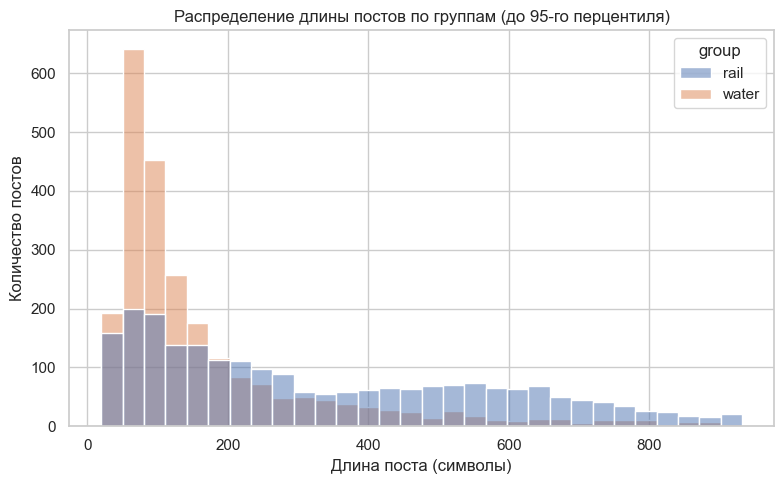

In [34]:
q95 = df["text_len"].quantile(0.95)

plt.figure(figsize=(8, 5))
sns.histplot(
    data=df[df["text_len"] <= q95],
    x="text_len",
    hue="group",
    bins=30,
    kde=False,
    common_norm=False,
)
plt.xlabel("Длина поста (символы)")
plt.ylabel("Количество постов")
plt.title("Распределение длины постов по группам (до 95-го перцентиля)")
plt.tight_layout()
plt.show()

### 5.2. Баланс классов

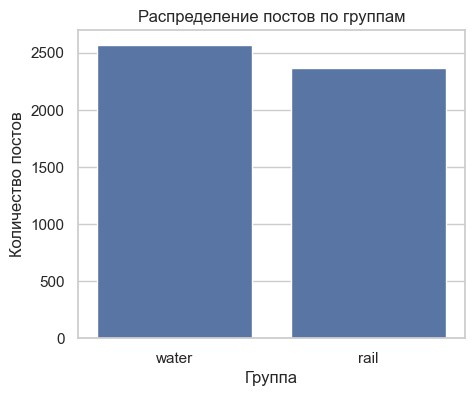

In [37]:
group_counts = df["group"].value_counts().reset_index()
group_counts.columns = ["group", "count"]
group_counts

plt.figure(figsize=(5, 4))
sns.barplot(data=group_counts, x="group", y="count")
plt.xlabel("Группа")
plt.ylabel("Количество постов")
plt.title("Распределение постов по группам")
plt.show()

### 5.3. Частотный словарь лемм по группам

Для каждого класса считаю топ-20 наиболее частотных лемм. Это позволяет увидеть, какая лексика характерна для железнодорожной и водной тематик.

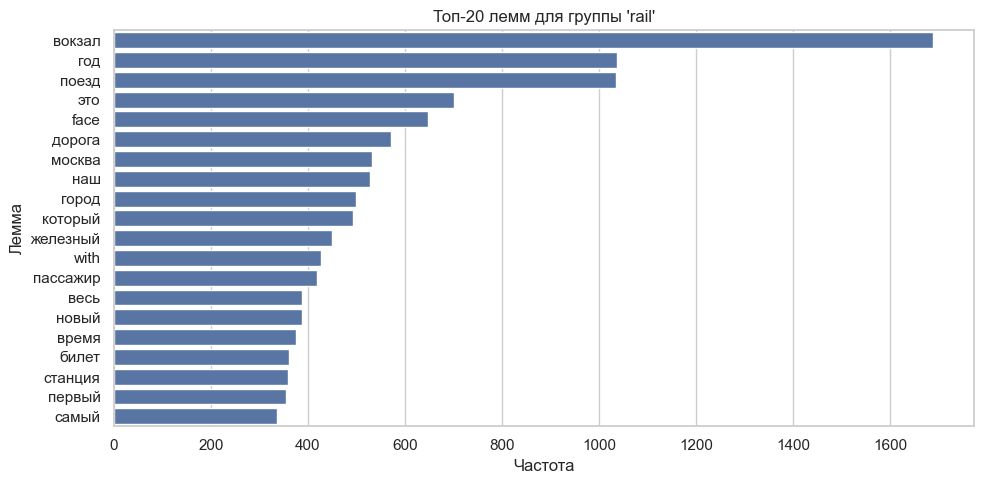

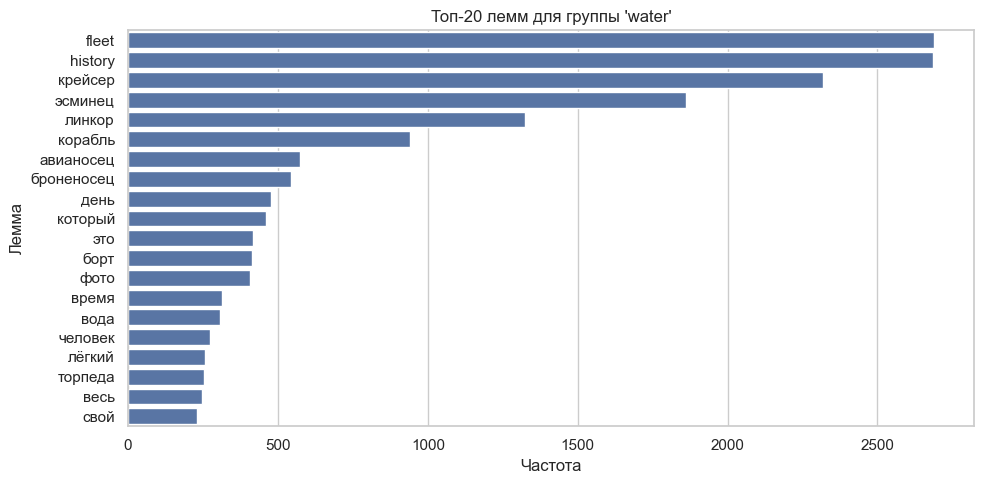

In [ ]:
def get_top_lemmas(df_subset, n_top=20):
    """
    Считает топ-n лемм в подтаблице с колонкой text_norm.
    """
    counter = Counter()
    for text in df_subset["text_norm"]:
        if not isinstance(text, str):
            continue
        tokens = text.split()
        counter.update(tokens)
    return counter.most_common(n_top)

top_rail = get_top_lemmas(df[df["group"] == "rail"], n_top=20)
top_water = get_top_lemmas(df[df["group"] == "water"], n_top=20)

top_rail_df = pd.DataFrame(top_rail, columns=["lemma", "freq"])
top_water_df = pd.DataFrame(top_water, columns=["lemma", "freq"])

plt.figure(figsize=(10, 5))
sns.barplot(data=top_rail_df, x="freq", y="lemma")
plt.xlabel("Частота")
plt.ylabel("Лемма")
plt.title("Топ-20 лемм для группы 'rail'")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_water_df, x="freq", y="lemma")
plt.xlabel("Частота")
plt.ylabel("Лемма")
plt.title("Топ-20 лемм для группы 'water'")
plt.tight_layout()
plt.show()

## 6. Подготовка данных для обучения моделей

### 6.1. Разделение на обучающую и тестовую выборки

Разделяем корпус нормализованных текстов и меток классов на обучающую и тестовую части (80/20) с сохранением пропорций классов (`stratify=y`).

In [ ]:
X = df["text_norm"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       
    random_state=42,
    stratify=y       
)

print("Размер train:", X_train.shape[0])
print("Размер test:", X_test.shape[0])
print("\nРаспределение классов в train:")
print(y_train.value_counts())
print("\nРаспределение классов в test:")
print(y_test.value_counts())

Размер train: 3953
Размер test: 989

Распределение классов в train:
target
1    2056
0    1897
Name: count, dtype: int64

Распределение классов в test:
target
1    514
0    475
Name: count, dtype: int64


### 6.2. Векторизация текстов методом TF-IDF

Строим числовое представление текстов с помощью `TfidfVectorizer`. Используем униграммы и биграммы, ограничиваем размер словаря и отбрасываем слишком редкие термы.  

Полученные матрицы `X_train_tfidf` и `X_test_tfidf` подаются на вход моделям классификации.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),    
    max_features=20000,   
    min_df=5              
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

TF-IDF train shape: (3953, 5840)
TF-IDF test shape: (989, 5840)


## 7. Обучение и оценка моделей классификации

### 7.1. Модель Multinomial Naive Bayes

Обучаем мультиномиальный наивный Байес на TF-IDF-признаках обучающей выборки и оцениваем качество на тесте.  

Считаем accuracy и F1-мера по классам, а также строим матрицу ошибок.

In [27]:
# Обучаем базовую модель
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

# Предсказания на тесте
y_pred_nb = nb_clf.predict(X_test_tfidf)

# Метрики
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy (Naive Bayes): {acc_nb:.3f}\n")

print("Отчёт по классам (Naive Bayes):")
print(classification_report(y_test, y_pred_nb, target_names=["rail", "water"]))

Accuracy (Naive Bayes): 0.998

Отчёт по классам (Naive Bayes):
              precision    recall  f1-score   support

        rail       1.00      1.00      1.00       475
       water       1.00      1.00      1.00       514

    accuracy                           1.00       989
   macro avg       1.00      1.00      1.00       989
weighted avg       1.00      1.00      1.00       989



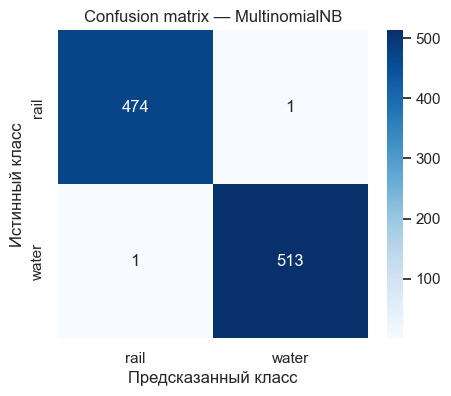

In [28]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["rail", "water"],
    yticklabels=["rail", "water"]
)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion matrix — MultinomialNB")
plt.show()

### 7.2. Модель логистической регрессии

Обучаем логистическую регрессию на тех же TF-IDF-признаках. Сравниваем метрики с наивным Байесом и строим матрицу ошибок. Дополнительно используем веса логистической регрессии для интерпретации наиболее информативных признаков.

In [ ]:
logreg_clf = LogisticRegression(
    max_iter=1000,   
    n_jobs=-1,      
)

logreg_clf.fit(X_train_tfidf, y_train)

y_pred_lr = logreg_clf.predict(X_test_tfidf)

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy (Logistic Regression): {acc_lr:.3f}\n")

print("Отчёт по классам (Logistic Regression):")
print(classification_report(y_test, y_pred_lr, target_names=["rail", "water"]))

Accuracy (Logistic Regression): 0.999

Отчёт по классам (Logistic Regression):
              precision    recall  f1-score   support

        rail       1.00      1.00      1.00       475
       water       1.00      1.00      1.00       514

    accuracy                           1.00       989
   macro avg       1.00      1.00      1.00       989
weighted avg       1.00      1.00      1.00       989



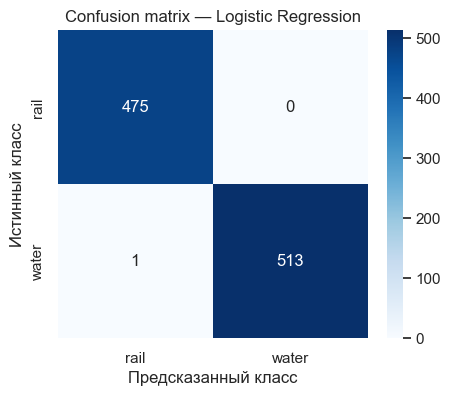

In [30]:
cm_lr = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_lr,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["rail", "water"],
    yticklabels=["rail", "water"]
)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion matrix — Logistic Regression")
plt.show()

## 8. Интерпретация признаков

На основе коэффициентов логистической регрессии выделяем термы и биграммы, которые сильнее всего ассоциированы с каждым классом.

Отдельно смотрим топ-термы для железнодорожной тематики (*rail*) и для водного транспорта (*water*) и анализируем, какие слова и выражения чаще всего «тянут» решение модели в сторону соответствующего класса.

In [ ]:
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

coefs = logreg_clf.coef_[0]

top_positive_indices = np.argsort(coefs)[-20:]  
top_negative_indices = np.argsort(coefs)[:20]    

print("Топ-20 признаков для класса 'rail' (target=0):")
for idx in top_negative_indices:
    print(f"{feature_names[idx]:<25} {coefs[idx]:.3f}")

print("\nТоп-20 признаков для класса 'water' (target=1):")
for idx in top_positive_indices:
    print(f"{feature_names[idx]:<25} {coefs[idx]:.3f}")

Топ-20 признаков для класса 'rail' (target=0):
вокзал                    -3.182
поезд                     -2.539
face                      -2.051
дорога                    -1.755
наш                       -1.751
железный дорога           -1.421
год                       -1.416
москва                    -1.354
город                     -1.317
путешествие               -1.291
with                      -1.273
железный                  -1.259
heart                     -1.240
станция                   -1.206
комментарий               -1.184
билет                     -1.177
red                       -1.157
вагон                     -1.014
face with                 -0.986
locomotive                -0.977

Топ-20 признаков для класса 'water' (target=1):
адмирал                   1.035
башня                     1.229
флот                      1.263
верфь                     1.289
борт                      1.497
броненосец fleet          1.680
авианосец fleet           1.789
фото                

## 9. Демонстрация работы модели на произвольных примерах

Определяем вспомогательные функции:

- `preprocess_single_text` — полный цикл предобработки одного текста  (очистка, нормализация);
- `classify` — применение обученной модели к произвольной строке: вывод исходного и нормализованного текста, предсказанной группы и, при необходимости, вероятностей по классам.

In [ ]:
inv_label_mapping = {0: "rail", 1: "water"}


def preprocess_single_text(raw_text: str) -> str:
    """
    Полный цикл предобработки для одного текста:
    - базовая очистка (clean_text)
    - нормализация (normalize_text)
    Возвращает нормализованную строку.
    """
    cleaned = clean_text(raw_text)
    normalized = normalize_text(cleaned)
    return normalized


def classify(text: str, model=logreg_clf, vectorizer=tfidf_vectorizer):
    """
    Классификация одного текста:
    - предобработка
    - преобразование в TF-IDF
    - предсказание класса и вероятностей
    """
    norm_text = preprocess_single_text(text)
    
    if not norm_text.strip():
        print("После предобработки текст пуст — модель не может его классифицировать.")
        return None

    X_vec = vectorizer.transform([norm_text])

    y_pred = model.predict(X_vec)[0]

    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_vec)[0]
        proba_dict = {
            inv_label_mapping[cls]: float(p) for cls, p in zip(model.classes_, proba)
        }
    else:
        proba_dict = None

    result = {
        "raw_text": text,
        "normalized_text": norm_text,
        "predicted_class": int(y_pred),
        "predicted_group": inv_label_mapping[int(y_pred)],
        "probabilities": proba_dict,
    }

    print("Исходный текст:")
    print(text)
    print("\nНормализованный текст:")
    print(norm_text)
    print("\nПредсказанная группа:", result["predicted_group"])
    if proba_dict is not None:
        print("Вероятности по классам:")
        for g, p in proba_dict.items():
            print(f"  {g}: {p:.3f}")

    return result


### 9.1. Примеры классификации тестовых предложений

Проверил работу финальной модели на нескольких реальных примерах постов из корпуса.

In [ ]:
def demo_real_examples(group_label, n=3):
    examples = df[df["group"] == group_label].sample(n, random_state=42)
    for i, row in examples.iterrows():
        print("=" * 80)
        classify(row["text_stripped"])
        print()

print("Примеры реальных постов из группы 'rail':")
demo_real_examples("rail", n=3)

print("Примеры реальных постов из группы 'water':")
demo_real_examples("water", n=3)

Примеры реальных постов из группы 'rail':
Исходный текст:
🥳Сегодня на Павелецком вокзале Москвы открылся зал ожидания Центра содействия мобильности ОАО "РЖД". 
 
На площади в 100 кв. м разместили: 
➡Зону регистрации посетителей; 
➡Комфортные места ожидания, в том числе для пассажиров с детьми; 
➡Гардероб; 
➡Адаптированные санитарные комнаты и душ. 
 
Для слабослышащих установили индукционное оборудование, а для пассажиров с нарушениями опорно-двигательного аппарата и передвигающихся в кресле-коляске — удобные посадочные места. Для людей с ограниченными возможностями по зрению — информационные мнемосхемы, выполненные с применением шрифта Брайля. Не забыли и о четвероногих помощниках — в зале ожидания предусмотрены места для собак-проводников. 
 
В ближайшее время запланировано открытие залов ожидания для маломобильных посетителей на вокзалах Самара, Ростов-Главный и Краснодар.

Нормализованный текст:
partying face сегодня павелецкий вокзал москва открыться зал ожидание центр содействие 

---

## 10. Выводы по результатам экспериментов

Обе использованные модели (Multinomial Naive Bayes и логистическая регрессия) показали практически идеальное качество на тестовой выборке: accuracy и F1-мера близки к 1.0, а матрицы ошибок не содержат неверных классификаций.  

Это означает, что выбранные тематические сообщества хорошо различаются по лексике, а простого конвейера предобработки + TF-IDF + линейная модель 
достаточно для успешной классификации постов по двум видам транспорта.